### Assignment 05 - Population Analysis
#### Differences Between the Sexes by Age in Ireland

This notebook analyses the **differences between the sexes by age** using CSO population data for Ireland.

**It includes:**
- The **weighted mean age** for each sex
- The **population difference between the sexes by age**
- A **focus group** analysis around a chosen age (**35 ± 5** years)
- The **region** in Ireland with the biggest sex population difference for that focus age range



#### 1) Import libraries and load the dataset

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

# Display options (optional)
pd.set_option('display.max_columns', None)

# Load the CSO dataset
csv_path = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\My-Work\Week-5\cso-populationbyage.csv"
df = pd.read_csv(csv_path)

# Quick peek
print(df.head(3))
print(df.info())


  Statistic Label  CensusYear         Sex Single Year of Age  \
0      Population        2022  Both sexes           All ages   
1      Population        2022  Both sexes           All ages   
2      Population        2022  Both sexes           All ages   

  Administrative Counties    UNIT    VALUE  
0                 Ireland  Number  5149139  
1   Carlow County Council  Number    61968  
2     Dublin City Council  Number   592713  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9792 entries, 0 to 9791
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Statistic Label          9792 non-null   object
 1   CensusYear               9792 non-null   int64 
 2   Sex                      9792 non-null   object
 3   Single Year of Age       9792 non-null   object
 4   Administrative Counties  9792 non-null   object
 5   UNIT                     9792 non-null   object
 6   VALUE                    979

#### 2) Filter for Ireland and clean the Age column

In [2]:

# Keep only Ireland rows
df_Ireland = df[df["Administrative Counties"] == "Ireland"].copy()

# Ensure VALUE is numeric
df_Ireland["VALUE"] = pd.to_numeric(df_Ireland["VALUE"], errors="coerce")

# Keep only rows that are single years of age (strings like 'Under 1 year', '17 years', '100 years and over')
df_Ireland = df_Ireland[df_Ireland["Single Year of Age"].str.contains("Under|year", case=False, na=False)]

# Clean 'Single Year of Age' into numeric Age
df_Ireland["Age"] = (
    df_Ireland["Single Year of Age"]
    .str.replace("Under 1 year", "0", regex=False)
    .str.replace("100 years and over", "100", regex=False)
    .str.replace(" years", "", regex=False)
    .str.replace(" year", "", regex=False)
)

# Keep only numeric ages and convert to int
df_Ireland = df_Ireland[df_Ireland["Age"].str.isnumeric()]
df_Ireland["Age"] = df_Ireland["Age"].astype(int)

df_Ireland[["Age", "Sex", "VALUE"]].head()


,Age,Sex,VALUE
32,0,Both sexes,57796
64,1,Both sexes,56420
96,2,Both sexes,59210
128,3,Both sexes,60484
160,4,Both sexes,61505


#### 3) Population by Age and Sex (pivot + line plot)

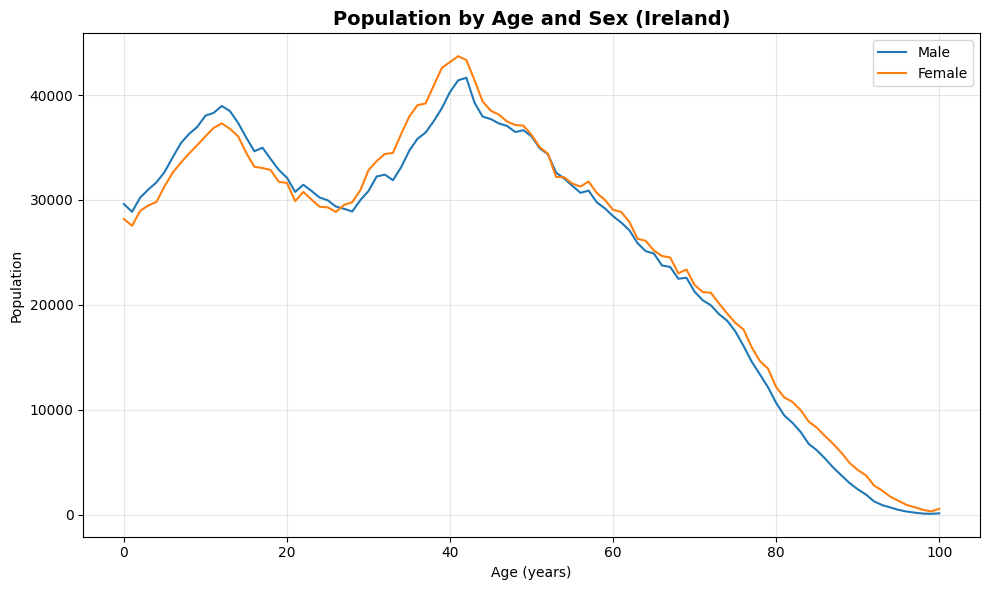

Sex,Age,Both sexes,Female,Male
0,0,57796,28186,29610
1,1,56420,27545,28875
2,2,59210,28974,30236
3,3,60484,29483,31001
4,4,61505,29819,31686


In [3]:

# Pivot: rows = Age, columns = Sex, values = summed population
pivot = df_Ireland.pivot_table(index="Age", columns="Sex", values="VALUE", aggfunc="sum").reset_index()

# Plot male vs female population by age
plt.figure(figsize=(10,6))
if "Male" in pivot.columns:
    plt.plot(pivot["Age"], pivot["Male"], label="Male")
if "Female" in pivot.columns:
    plt.plot(pivot["Age"], pivot["Female"], label="Female")
plt.title("Population by Age and Sex (Ireland)", fontweight="bold", fontsize=14)
plt.xlabel("Age (years)")
plt.ylabel("Population")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

pivot.head()


#### 4) Weighted mean age (by sex)

In [4]:

wm_results = {}

if "Male" in pivot.columns and pivot["Male"].sum() > 0:
    wm_results["Male"] = float((pivot["Age"] * pivot["Male"]).sum() / pivot["Male"].sum())

if "Female" in pivot.columns and pivot["Female"].sum() > 0:
    wm_results["Female"] = float((pivot["Age"] * pivot["Female"]).sum() / pivot["Female"].sum())

print("Weighted Mean Age (by sex):")
for k, v in wm_results.items():
    print(f"  {k}: {v:.2f}")


Weighted Mean Age (by sex):
  Male: 37.74
  Female: 38.94


#### 5) Difference between the sexes by age (Male - Female)

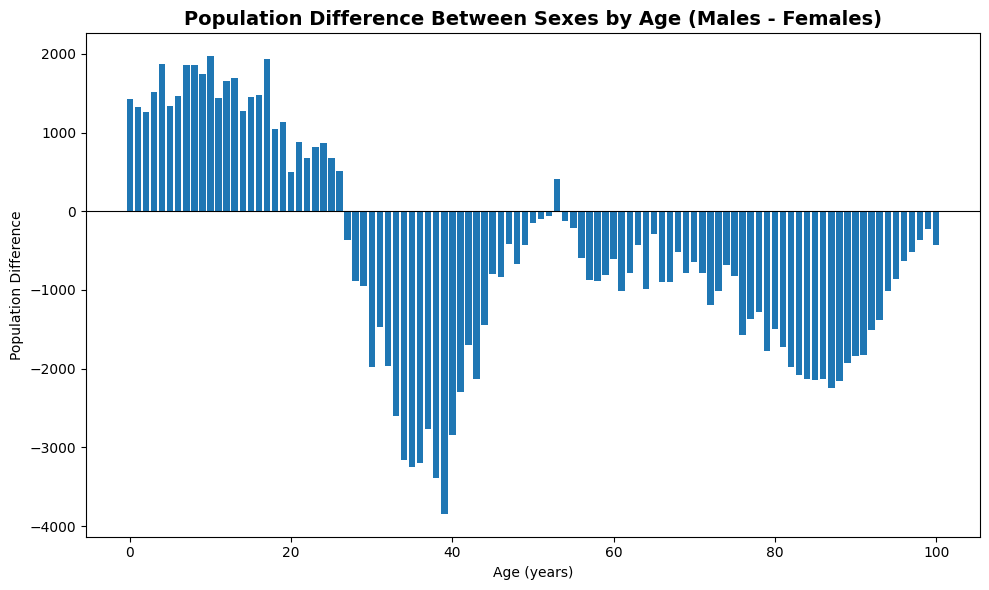

Sex,Age,Both sexes,Female,Male,Difference (M-F)
0,0,57796,28186,29610,1424
1,1,56420,27545,28875,1330
2,2,59210,28974,30236,1262
3,3,60484,29483,31001,1518
4,4,61505,29819,31686,1867


In [5]:

# Compute difference if both columns present
if all(c in pivot.columns for c in ["Male", "Female"]):
    pivot["Difference (M-F)"] = pivot["Male"] - pivot["Female"]
    
    plt.figure(figsize=(10,6))
    plt.bar(pivot["Age"], pivot["Difference (M-F)"])
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title("Population Difference Between Sexes by Age (Males - Females)", fontweight="bold", fontsize=14)
    plt.xlabel("Age (years)")
    plt.ylabel("Population Difference")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns ('Male' and 'Female') not found in the pivot.")
    
pivot.head()


#### 6) Focus group (35 ± 5 years): population difference between the sexes

In [6]:

focus_age = 35
low, high = focus_age - 5, focus_age + 5

fg = pivot[(pivot["Age"] >= low) & (pivot["Age"] <= high)].copy()

if all(c in fg.columns for c in ["Male", "Female"]) and not fg.empty:
    total_male = int(fg["Male"].sum())
    total_female = int(fg["Female"].sum())
    diff = total_male - total_female
    print(f"Focus Age Range: {low}–{high}")
    print(f"  Total Male:   {total_male:,}")
    print(f"  Total Female: {total_female:,}")
    print(f"  Difference (M - F): {diff:,}")
else:
    print("Insufficient data to compute focus group difference (missing Male/Female columns or empty range).")

fg[["Age"] + [c for c in ["Male","Female","Difference (M-F)"] if c in fg.columns]].head(20)


Focus Age Range: 30–40
  Total Male:   384,030
  Total Female: 414,506
  Difference (M - F): -30,476


Sex,Age,Male,Female,Difference (M-F)
30,30,30858,32841,-1983
31,31,32237,33710,-1473
32,32,32413,34382,-1969
33,33,31888,34489,-2601
34,34,33121,36284,-3163
35,35,34695,37940,-3245
36,36,35828,39030,-3202
37,37,36427,39193,-2766
38,38,37513,40902,-3389
39,39,38749,42592,-3843


#### 7) Region with the biggest population difference (35 ± 5 years)

In [7]:

# Prepare full DF with numeric Age for the same focus range
df_focus = df.copy()
df_focus["VALUE"] = pd.to_numeric(df_focus["VALUE"], errors="coerce")

# Parse numeric age from 'Single Year of Age'
age_extracted = df_focus["Single Year of Age"].str.extract(r"(\d+)")
df_focus["Age"] = pd.to_numeric(age_extracted[0], errors="coerce")

# Keep only valid age rows in focus range
df_focus = df_focus[df_focus["Age"].between(low, high, inclusive="both")]

# Pivot by region and sex
region_pivot = df_focus.pivot_table(
    index="Administrative Counties",
    columns="Sex",
    values="VALUE",
    aggfunc="sum"
).fillna(0)

# Compute absolute difference
if all(c in region_pivot.columns for c in ["Male", "Female"]):
    region_pivot["Difference (M-F)"] = (region_pivot["Male"] - region_pivot["Female"]).abs()
  

    # Find region with the largest absolute difference
    largest_region = region_pivot["Difference (M-F)"].idxmax()
    largest_value = int(region_pivot.loc[largest_region, "Difference (M-F)"])
    print(f"Largest absolute sex difference (ages {low}–{high}):")
    print(f"  Region: {largest_region}")
    print(f"  |Male - Female|: {largest_value:,}")
else:
    print("Required columns ('Male' and 'Female') not present in regional pivot.")

region_pivot.sort_values("Difference (M-F)", ascending=False).head(10)


Largest absolute sex difference (ages 30–40):
  Region: Ireland
  |Male - Female|: 30,476


Sex,Both sexes,Female,Male,Difference (M-F)
Administrative Counties,,,,
Ireland,798536,414506,384030,30476
Fingal County Council,55242,29092,26150,2942
Cork County Council,50251,26545,23706,2839
South Dublin County Council,49998,26361,23637,2724
Kildare County Council,39273,20602,18671,1931
Meath County Council,33696,17715,15981,1734
Wicklow County Council,22281,11943,10338,1605
Galway County Council,26325,13904,12421,1483
Dún Laoghaire Rathdown County Council,35524,18450,17074,1376
